In [1]:
import copy
import os, sys
import numpy as np
import pandas as pd

import joblib

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches

from scipy.stats.mstats import zscore
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid
from scipy.stats import sem

from nilearn.signal import clean

In [2]:
os.chdir('../')

In [3]:
# loa my modules
from src.PMA_SCCA import SCCA
from src.utils import load_pkl
from src.visualise import *
from src.file_io import save_output

# Cleaning confounds

We first created the confound matrix according to Smith et al. (2015). The confound variables are motion (Jenkinson), sex, and age. We also created squared confound measures to help account for potentially nonlinear effects of these confounds.

In [4]:
def clean_confound(RS, COG, confmat):
    '''
    We first created the confound matrix according to Smith et al. (2015). 
    The confound variables are motion (Jenkinson), sex, and age. 
    We also created squared confound measures to help account for potentially nonlinear effects of these confounds.
    '''

    # regress out confound
    z_confound = zscore(confmat)
    # squared measures to help account for potentially nonlinear effects of these confounds
    z2_confound = z_confound ** 2
    conf_mat = np.hstack((z_confound, z2_confound))

    # clean signal
    RS_clean = clean(zscore(RS), confounds=conf_mat, detrend=False, standardize=False)
    COG_clean = clean(zscore(COG), confounds=conf_mat, detrend=False, standardize=False)

    return RS_clean, COG_clean, conf_mat

# K-Fold CV for parameters/model selection

## Penalty selection CV

Grid search range, set up inner and outer folds and the parameter grid

In [5]:
def search_grid_scca(reg_X, reg_Y):
    '''
    reg_X, reg_Y: tuple
    (lower limit, upper limit)

    n_selected: list
    list of component number
    '''

    param_setting = {
        'reg_X': np.arange(reg_X[0], reg_X[1] + 0.1, 0.1),
        'reg_Y': np.arange(reg_Y[0], reg_Y[1] + 0.1, 0.1),}
    param_grid = ParameterGrid(param_setting)
    return param_grid

In [6]:
def nested_kfold_cv_scca(X, Y, R=None, n_selected=4, out_folds=5, in_folds=5, reg_X=(0.1, 1), reg_Y=(0.1, 1)):
    '''
    TBC
    '''
    grid = search_grid_scca(reg_X, reg_Y)
    KF_out = KFold(n_splits=out_folds, shuffle=True, random_state=1)
    KF_in = KFold(n_splits=in_folds, shuffle=True, random_state=1)
    
    n_penX = int(reg_X[1] * 10 - reg_X[0] + 1)
    n_penY = int(reg_Y[1] * 10 - reg_Y[0] + 1)
    
    best_model = None
    best_score = 1
    pred_scores = []
    para_search = np.zeros((n_penX, n_penY, out_folds))
    for i, (train_idx, test_idx) in enumerate(KF_out.split(X)):
        print('Fold {0:}/{1:}'.format(i + 1, out_folds))
        X_discovery, X_test = X[train_idx], X[test_idx]
        Y_discovery, Y_test = Y[train_idx], Y[test_idx]

        para_mean_score = np.zeros((n_penX, n_penY))
        for j, parameters in enumerate(iter(grid)):
            para_idx = np.unravel_index(j, para_mean_score.shape) # (C_x,C_y)
            model = SCCA(n_components=n_selected, scale=True, n_iter=100,
                         penX=parameters['reg_X'], penY=parameters['reg_Y'],
                        )
            inner_scores = []
            for k, (train_idx, test_idx) in enumerate(KF_in.split(X_discovery)):

                # find best weights for this hyper parameter set
                X_train, X_confirm = X_discovery[train_idx], X_discovery[test_idx]
                Y_train, Y_confirm = Y_discovery[train_idx], Y_discovery[test_idx]
                model.fit(X_train, Y_train)
                
                pred_error = model.score(X_confirm, Y_confirm)

                inner_scores.append(pred_error)
                    
            para_mean_score[para_idx] = np.mean(inner_scores)
        
        idx = np.argmin(para_mean_score)
        d_idx = np.unravel_index(idx, para_mean_score.shape)
        C = 0.1 * (np.array(d_idx) + 1)
        
        para_best_model = SCCA(n_components=n_selected, scale=True, n_iter=100,
                         penX=C[0], penY=C[1],
                        )
        para_best_model.fit(X_discovery, Y_discovery)
        pred_error = para_best_model.score(X_test, Y_test)
        pred_scores.append(pred_error)
        
        if pred_error < best_score:
            best_score = pred_error
            best_model = copy.deepcopy(para_best_model)
            print('\nNew Best model: \n {:} components,penalty x: {:}, penalty y: {:}\nOOS performance: {}'.format(
            best_model.n_components, best_model.penX,  best_model.penY,  best_score))
        para_search[..., i] = para_mean_score
    
    # final parameter
    print('\nBest parameters based on outer fold ev results: X-{:}; Y-{:}\nFinal test error: {:}'.format(
            best_model.penX, best_model.penY, best_score))
    
    return (para_search, best_model, pred_scores)

# permutation test

In [7]:
def permutate_scca(X, Y, model, n_permute=1000):
    '''
    find the best variates among all components
    by calculating the FWE-corrected p-value based on FDR
    '''
    model.fit(X, Y)
    d = model.cancorr_
    n_mod_select = model.n_components
    permute_cancorr = np.zeros((n_permute, n_mod_select))
    np.random.seed(42)
    for i in range(n_permute):
        # permute the cognitive measures
        per_idx = np.random.permutation(Y.shape[0])
        cur_y = Y[per_idx, :]
        permute_model = copy.deepcopy(model)
        permute_model.fit(X, cur_y)
        cur_cancorr = permute_model.cancorr_
        permute_cancorr[i, :] = cur_cancorr

    # calculate the FWE-corrected p value
    p_val = (1 + np.sum(d < np.repeat(permute_cancorr[1:, 0:1], n_mod_select, axis=1),0)) / float(n_permute)
    results = {
        'Component': range(1, n_mod_select + 1),
        'P-values': p_val,
        'alpah0.05': p_val < 0.05,
        'alpah0.01': p_val < 0.01,
        'alpah0.001': p_val < 0.001,
    }
    
    df_permute = pd.DataFrame.from_dict(results).set_index('Component')
    return df_permute

In [8]:
def parameter_grid(para, pred_evs, i):
    '''
    plot the output of the grid search
    '''
    set_text_size(12)

    idx = np.argmin(para)
    d_idx = np.unravel_index(idx, para.shape)
    
    title = 'Sparsity Search - Fold {}'.format(i + 1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hm = ax.matshow(para.T, vmin=0, vmax=0.5, cmap="inferno_r")
    ax.set_xticklabels(np.array(range(0, 10)) * 0.1)
    ax.set_yticklabels(np.array(range(0, 10)) * 0.1)
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('MRIQ')
    ax.set_title(title)
    ax.xaxis.set_ticks_position('bottom')
    fig.colorbar(hm, label='CV Estimate of Prediction Error')
    # Create a Rectangle patch
    rect = patches.Rectangle(np.array(d_idx) - 0.5, 1, 1,linewidth=2,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    # add prediction error
    ax.annotate('Test Error:{:.3f}'.format(pred_evs), (0,0), (0, -40), 
                     xycoords='axes fraction', textcoords='offset points', va='top',
                     fontstyle='italic', fontsize=10)
    return fig

# Run the thing

In [9]:
dat_path = './data/processed/dict_SCCA_data_prepro_06092017.pkl'
# load data
dataset = load_pkl(dat_path)

FC_yeo7 = dataset['FC_Yeo7']
MRIQ    = dataset['MRIQ']
mot     = dataset['Motion_Jenkinson']
sex     = dataset['Gender']
age     = dataset['Age']
confound_raw = np.hstack((mot, sex, age))

In [10]:
X, Y, R = clean_confound(FC_yeo7, MRIQ, confound_raw)
out_folds = 5
in_folds = 5
n_selected = 4

In [11]:
%%time
para_search, best_model, pred_errors = nested_kfold_cv_scca(
    X, Y, R, n_selected, 
    out_folds=5, in_folds=5, 
    reg_X=(0.1, 0.9), reg_Y=(0.1, 0.9)
)

Fold 1/5

New Best model: 
 4 components,penalty x: 0.6, penalty y: 0.1
OOS performance: 0.0606923533332
Fold 2/5
Fold 3/5

New Best model: 
 4 components,penalty x: 0.9, penalty y: 0.3
OOS performance: 0.0450093747515
Fold 4/5
Fold 5/5

New Best model: 
 4 components,penalty x: 0.9, penalty y: 0.3
OOS performance: 0.0398340469137

Best parameters based on outer fold ev results: X-0.9; Y-0.3
Final test error: 0.0398340469137
CPU times: user 6min 16s, sys: 4.92 s, total: 6min 21s
Wall time: 7min 56s


In [12]:
best_model.fit(X, Y)
u, v = best_model.u, best_model.v
joblib.dump(best_model, 
            './models/SCCA_Yeo7_revision_zscore_{:1d}_{:.2f}_{:.2f}.pkl'.format(
                best_model.n_components, best_model.penX, best_model.penY))

['./models/SCCA_Yeo7_revision_zscore_4_0.90_0.30.pkl']

In [13]:
set_text_size(12)
figs = show_results(u, v, dataset['Yeo7_ROIs'], dataset['MRIQ_labels'], rank_v=True, sparse=True)

write_png('./reports/revision/bestModel_zscore_component_{:}.png', figs)

In [14]:
X_scores, Y_scores, df_z = save_output(dataset, best_model, X, Y, path=None)

In [15]:
df_z.to_csv('./data/processed/NYCQ_CCA_score_revision_zscore_{0:1d}_{1:.1f}_{2:.1f}.csv'.format(
            best_model.n_components, best_model.penX, best_model.penY))
df_z.to_pickle('./data/processed/NYCQ_CCA_score_revision_zscore_{0:1d}_{1:.1f}_{2:.1f}.pkl'.format(
            best_model.n_components, best_model.penX, best_model.penY))

In [16]:
df_permute = permutate_scca(X, Y, best_model, n_permute=1000)
df_permute

,P-values,alpah0.001,alpah0.01,alpah0.05
Component,,,,
1,0.826,False,False,False
2,0.820,False,False,False
3,1.000,False,False,False
4,0.990,False,False,False


In [17]:
lst =[]
for i in range(5):
    lst.append(parameter_grid(para_search[..., i], pred_errors[i], i))
write_png('./reports/revision/grid_zscore_fold_{:}.png', lst)

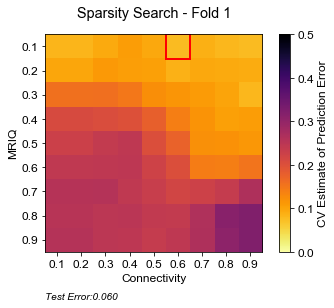

In [18]:
plt.close("all")
parameter_grid(para_search.mean(axis=2), sum(pred_errors)/5, 0)
plt.show()